<a href="https://colab.research.google.com/github/peeyushsinghal/ContinualLearning/blob/main/EWC_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
%matplotlib inline
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
from torch.autograd import Variable
from copy import deepcopy
from tqdm import tqdm

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [ ]:
def mnist_imshow(img):
    plt.imshow(img.reshape([28,28]), cmap="gray")
    plt.axis('off')
    plt.show()

In [124]:
#@title Experiment Constants
epochs = 2
epochs = 50
lr = 1e-3
batch_size = 128
sample_size = 200
hidden_size = 200
num_task = 3 # Number of tasks, task 1 we would not have any permutation
batch_size = 128

## Dataset and Dataloader

In [ ]:
class PermutedMNIST(datasets.MNIST):

    def __init__(self, root="~/.torch/data/mnist", train=True, permute_idx=None):
        super(PermutedMNIST, self).__init__(root, train, download=True)
        assert len(permute_idx) == 28 * 28
        if self.train:
          # print("data", type(self.train_data),type(self.train_data[0]),self.train_data.shape, self.train_data[0].shape, self.train_data[0])
          self.training_data= torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.train_data])
          self.training_labels = self.train_labels
        else:
          self.testing_data = torch.stack([img.float().view(-1)[permute_idx] / 255 for img in self.test_data])
          self.testing_labels = self.test_labels

    def __getitem__(self, index):

        if self.train:
            img, target = self.training_data[index], self.training_labels[index]
        else:
            img, target = self.testing_data[index], self.testing_labels[index]

        return img, target

    def get_sample(self, sample_size):
        sample_idx = random.sample(range(len(self)), sample_size)
        return [img for img in self.training_data[sample_idx]]

In [ ]:
def get_permute_mnist():
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28)) # first time there is no shuffle
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                     batch_size=batch_size)
        print(f'Index for  task {i} \n {idx}')
        idx = random.sample(idx, len(idx))
    return train_loader, test_loader 


train_loader, test_loader = get_permute_mnist()

Index for  task 0 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,

 ------task 0 --------
torch.Size([784])
label :  0


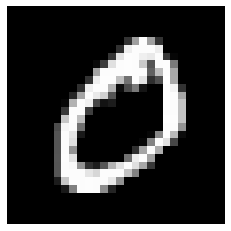

 ------task 1 --------
torch.Size([784])
label :  0


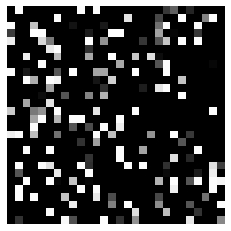

 ------task 2 --------
torch.Size([784])
label :  0


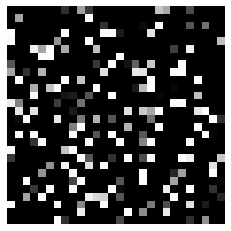

In [ ]:
t = 0
for i in range(num_task):
  print(f' ------task {i} --------')
  batch = next(iter(train_loader[i]))
  if t == 0:
    t = random.randint(1,len(batch))
  image, label = batch[0][t], batch[1][t]
  print (batch[0][t].shape)
  print("label : ", label.item())  
  mnist_imshow(image)


## Network
A simple network with only Linear layers

In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden_size=200):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

model = MLP().to(device)
summary(model, input_size=(1,784))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 200]         157,000
            Linear-2               [-1, 1, 200]          40,200
            Linear-3               [-1, 1, 200]          40,200
            Linear-4                [-1, 1, 10]           2,010
Total params: 239,410
Trainable params: 239,410
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.91
Estimated Total Size (MB): 0.92
----------------------------------------------------------------


## Normal Train Function

Variable Function - Used for Gradient [Reference](https://www.geeksforgeeks.org/variables-and-autograd-in-pytorch/)

In [ ]:
def variable(t: torch.Tensor, use_cuda=True, **kwargs):
  """
  Takes in a tensor and converts into a tensor with gradient
  We would need gradients of parameters, hence needed 
  """
  if torch.cuda.is_available() and use_cuda:
    t = t.cuda()
  return Variable(t, **kwargs)

In [ ]:
def normal_train(model: nn.Module, 
                 optimizer: torch.optim, 
                 data_loader: torch.utils.data.DataLoader):
  """
  Takes in a model architecture, trains its and returns average epoch loss
  """
  model.train()
  epoch_loss = 0
  for input, target in data_loader:
      input, target = variable(input), variable(target)
      optimizer.zero_grad()
      output = model(input)
      loss = F.cross_entropy(output, target)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
  return epoch_loss / len(data_loader)

## Normal Test Function

In [ ]:
def test(model: nn.Module, 
         data_loader: torch.utils.data.DataLoader):
    model.eval()
    correct = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        output = model(input)
        correct += (F.softmax(output, dim=1).max(dim=1)[1] == target).data.sum()
    return correct / len(data_loader.dataset)

## Elastic Weight Consolidation

In [ ]:
class EWC(object):
    def __init__(self, 
                 model: nn.Module, 
                 dataset: list):

        self.model = model
        self.dataset = dataset

        # default model params
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._diag_fisher()

        for n, p in deepcopy(self.params).items():
            self._means[n] = variable(p.data)

    def _diag_fisher(self):
        precision_matrices = {}
        for n, p in deepcopy(self.params).items():
            p.data.zero_()
            precision_matrices[n] = variable(p.data)

        self.model.eval() # we need to do one round of back propogation to understand the gradients of params
        # interestingly we dont have to always use model.train() to get the gradients
        for input in self.dataset:
            self.model.zero_grad()
            input = variable(input)
            output = self.model(input).view(1, -1)
            label = output.max(1)[1].view(-1)
            loss = F.nll_loss(F.log_softmax(output, dim=1), label)
            loss.backward()

            for n, p in self.model.named_parameters():
                precision_matrices[n].data += p.grad.data ** 2 / len(self.dataset)

        precision_matrices = {n: p for n, p in precision_matrices.items()}
        return precision_matrices

    def penalty(self, model: nn.Module):
        loss = 0
        for n, p in model.named_parameters():
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss

### EWC Train Function
This has got Penalties

In [120]:
def ewc_train(model: nn.Module, 
              optimizer: torch.optim, 
              data_loader: torch.utils.data.DataLoader,
              ewc: EWC, 
              importance: float): # importance is a hyperparam 
    model.train()
    epoch_loss = 0
    for input, target in data_loader:
        input, target = variable(input), variable(target)
        optimizer.zero_grad()
        output = model(input)
        ##-------Updated Loss Function-------###
        loss = F.cross_entropy(output, target) + importance * ewc.penalty(model)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    return epoch_loss / len(data_loader)


## Plot Functions

In [116]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v, label = "Task "+ str(t))
    plt.legend(loc = 'upper right')
    plt.title("Loss Plot")
    plt.show()

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_task * epochs)), v, label = "Task "+  str(t))
    plt.ylim(0, 1)
    plt.legend(loc = 'upper right')
    plt.title("Accuracy Plot")
    plt.show()

## Standard Process Execution

In [113]:
def standard_process(epochs, use_cuda=True, weight=True):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc = {}, {} # across tasks 
    for task in range(num_task):
        loss[task] = [] # per task loss
        acc[task] = [] # per task accuracy
        for _ in tqdm(range(epochs)):
            loss[task].append(normal_train(model, optimizer, train_loader[task]))
            for sub_task in range(task + 1):
                acc[sub_task].append(test(model, test_loader[sub_task]))
        if task == 0 and weight:
            weight = model.state_dict()
    return loss, acc, weight

In [125]:
#@title Training and Output of Standard Process
loss, acc, weight = standard_process(epochs) # The weights are used by EWC process

100%|██████████| 50/50 [04:15<00:00,  5.11s/it]


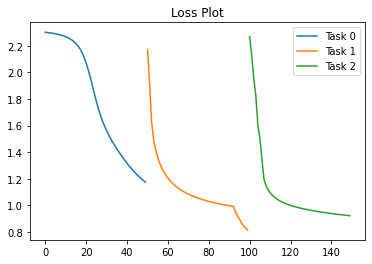

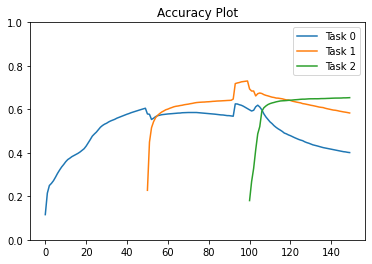

(None, None)

In [126]:
loss_plot(loss), accuracy_plot(acc)

In [127]:
(weight)

OrderedDict([('fc1.weight',
              tensor([[ 0.0319,  0.0169, -0.0140,  ...,  0.0280,  0.0269, -0.0357],
                      [-0.0006, -0.0162,  0.0313,  ..., -0.0052, -0.0190, -0.0439],
                      [-0.0128, -0.0255, -0.0037,  ...,  0.0091,  0.0011, -0.0171],
                      ...,
                      [ 0.0206,  0.0522, -0.0342,  ..., -0.0319,  0.0009, -0.0275],
                      [-0.0075, -0.0079, -0.0142,  ..., -0.0196,  0.0206,  0.0233],
                      [ 0.0086,  0.0160,  0.0047,  ..., -0.0069, -0.0366,  0.0045]])),
             ('fc1.bias',
              tensor([ 3.5735e-02,  1.5222e-02, -2.4375e-02,  1.6001e-02, -1.7563e-02,
                      -2.9967e-02,  5.0497e-02, -3.1193e-03, -7.5430e-03,  2.5895e-02,
                       1.5425e-02, -9.9276e-03,  1.1545e-02, -1.4305e-02,  6.2072e-02,
                       4.3924e-02,  1.1756e-02,  1.7072e-02,  3.9456e-02,  2.5933e-03,
                       1.7506e-02, -2.9858e-02,  3.4841e-02,  4.

## EWC Process Execution

In [128]:
def ewc_process(epochs, importance, use_cuda=True, weight=None):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc, ewc = {}, {}, {}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for _ in tqdm(range(epochs)):
                    loss[task].append(normal_train(model, optimizer, train_loader[task]))
                    acc[task].append(test(model, test_loader[task]))
        else:
            old_tasks = []
            for sub_task in range(task):
                old_tasks = old_tasks + train_loader[sub_task].dataset.get_sample(sample_size)
            old_tasks = random.sample(old_tasks, k=sample_size)
            for _ in tqdm(range(epochs)):
                loss[task].append(ewc_train(model, optimizer, train_loader[task], EWC(model, old_tasks), importance))
                for sub_task in range(task + 1):
                    acc[sub_task].append(test(model, test_loader[sub_task]))

    return loss, acc

In [129]:
#@title Training and Output of EWC Process
loss_ewc, acc_ewc = ewc_process(epochs, importance=1000)

100%|██████████| 50/50 [05:40<00:00,  6.82s/it]


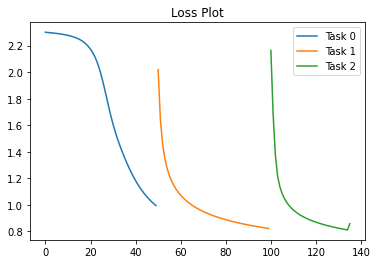

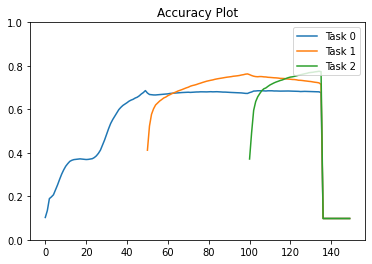

(None, None)

In [130]:
loss_plot(loss_ewc) , accuracy_plot(acc_ewc)

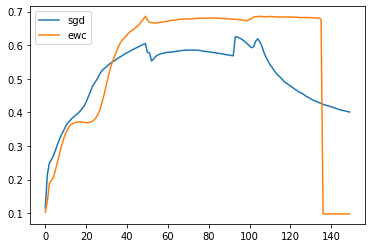

In [131]:
plt.plot(acc[0], label="sgd")
plt.plot(acc_ewc[0], label="ewc")
plt.legend()